# Cryptocurrency_Ransomware_Detection (Example Code)

## Problem Statement
Although cryptocurrencies have been around for a while, they continue to capture the imaginations of people from all walks of life. Some view them as the [Ultimate Democratic Tool](https://www.wired.com/insights/2014/04/bitcoin-ultimate-democratic-tool/), a way to guarantee a person is who they say they are without revealing any of that person's information. Unfortunately, that anonymity, along with their being completely digital, also makes cryptocurrencies attractive to people with more nefarious goals.

The inception of cryptocurrencies has allowed for crimes that [weren't previously possible](https://www.coindesk.com/bitcoin-is-aiding-the-ransomware-industry): ransomware attacks. Per [Wikipedia](https://en.wikipedia.org/wiki/Ransomware),


> Ransomware is a type of malware from cryptovirology that threatens to publish the victim's data or perpetually block access to it unless a ransom is paid.

The perpetrators of ransomware attacks are increasingly requesting bitcoin for their ransom, because of the near-anonymity bitcoin transactions provide.

What if there were some way, though, to identify that a bitcoin address was associated with ransomware based on the characteristics of individual bitcoin transactions? And that is the problem we have chosen to investigate.



The dataset we're using for this problem can be found [here](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset). From the description of the dataset, we already know


> White Bitcoin addresses are capped at 1K per day (Bitcoin has 800K addresses daily). <br>
Although we are certain about ransomware labels, we do not know if all white addresses are in fact not related to ransomware.<br>
When compared to non-ransomware addresses, ransomware addresses exhibit more profound right skewness in distributions of feature values.



Additionally, we know that the data contains the following fields and data types:


```
Description of fields in Bitcoin Heist data

Name             Data Type    Meas.    Description
----             ---------    -----    -----------
Address          nominal              string (bitcoin address)
Day              integer      0-365   day of the year (presumably no leap years?)
Year             ordered              calendar year
Length           integer     
Weight           continuous    
Count            integer               
Looped           integer               # that split coins; use dif paths; merge    
Neighbors        integer  
Income           integer               Satoshi amount (1 bitcoin = 100 million satoshis)
Label            nominal               string (ransomware family name or white, not known to be ransomware)
**Label_ind      binomial      0-1     indicator/dummy variable (1 = ransomware, 0 = white)
```



We will begin with our ETL:

## Extract, Transform, and Load the Data (ETL)
First we'll load the data from Google Drive, and import libraries:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve, cross_val_score, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

pd.set_option('display.float_format', lambda x: '%.5f' % x)
sns.set(style="whitegrid")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/EN685.648.81.SP21/Final Report/BitcoinHeistData.csv"
bitcoin_data = pd.read_csv(path)

In [ ]:
bitcoin_data.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.00833,1,0,2,100050000.00000,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.00024,1,0,1,100000000.00000,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.00000,1,0,2,200000000.00000,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.00391,1,0,2,71200000.00000,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.07285,456,0,1,200000000.00000,princetonLocky


Looks good! And now we also can get a quick sense of what the data looks at. We'll pull a quick `info` check for an initial look at each feature:

In [ ]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


Using `info`, we get information on all the data types. We can see that only `address` and `label` are represented as objects. There are no missing values.

## Exploratory Data Analysis (EDA)

#### Weight
Weight is a numeric variable. Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins in multiple addresses are each passed through a succession of merging transactions and accumulated in a final address. Weight represents information on the amount (what percent of
these transactions’ output?) of transactions. Weight of an address u, $W_u$, is defined as the sum of fraction
of coins that originate from a starter transaction and reach u. For example,


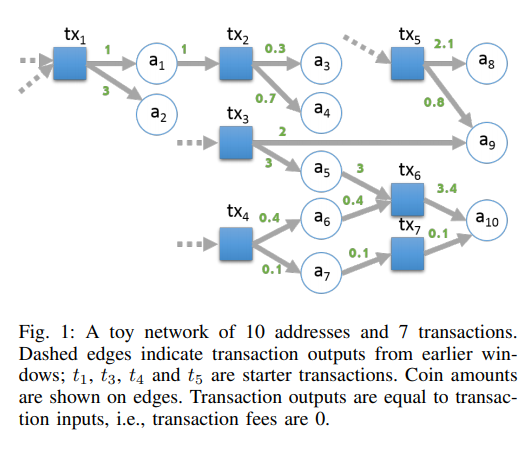



We assign each of the four transactions a weight of 1,
regardless of their output amounts *$\mathcal{A}^o$*(.). Addresses *$a_1$* and
*$a_2$* receive $W_{\alpha_1}$ = 1/|$\Gamma_{tx1}^o$
| = 1/2 and $W_{\alpha_2}$ = 1/|$\Gamma_{tx1}^o$
| = 1/2
from transaction *$tx_1$*, respectively. Address *$a_3$* receives 1/2 of
the weight from *$a_1$*. Hence, $W_{\alpha_3}$ = (1/2)×(1/2). Consider *$a_{10}$*
which receives weights from *$tx_3$* and *$tx_4$*. Weight of *$tx_3$* flows
through *$a_5$* and *$t_6$*, whereas the weight of *$tx_4$* flows through *$a_7$*
and *$tx_7$* to reach *$a_{10}$*. Hence, $W_{\alpha_{10}}$ = $W_{\alpha_7}$ + [$W_{\alpha_5}$ + $W_{\alpha_6}$
] =
(1/2) + [1/2 + 1/2].

Reference:
https://arxiv.org/pdf/1906.07852.pdf

Let's first look at the summary statistics for Weight to get a sense for the range.

In [ ]:
weight = bitcoin_data["weight"].describe()
print(weight)

count   2916697.00000
mean          0.54552
std           3.67426
min           0.00000
25%           0.02148
50%           0.25000
75%           0.88195
max        1943.74879
Name: weight, dtype: float64


The maximum weight is 1943.74879. The minimum weight is 3.6099999999999993e-94. The range is huge in weight variable. The difference between the amount of bitcoin holding is diverse. Second, let's look at the outliers in the boxplot.

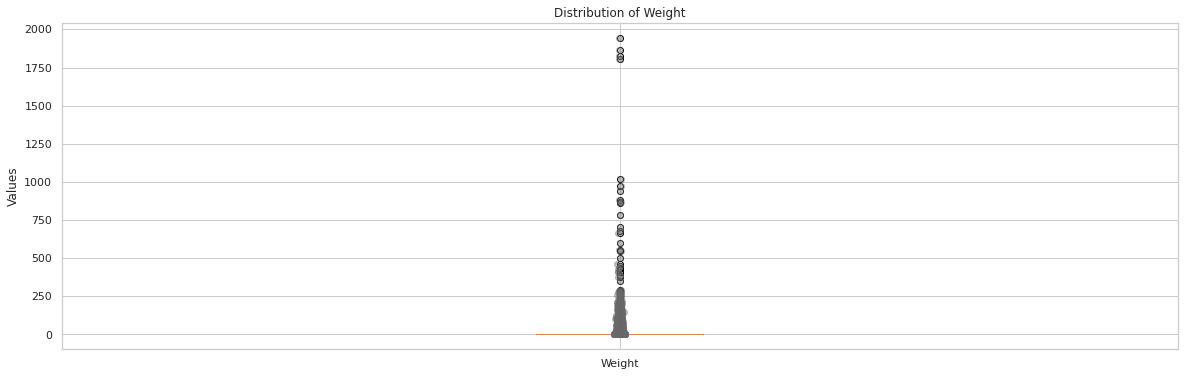

In [ ]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(bitcoin_data.weight, labels=["Weight"], showfliers=True, patch_artist=False, zorder=1)
axes.set_title("Distribution of Weight")
axes.set_ylabel("Values")
x = np.random.normal(1, 0.001, size=len(bitcoin_data["weight"]))
axes.plot(x, bitcoin_data["weight"], 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

It is difficulty to see the 25%, 50% and 75% qaurter because the numbers of outliers. The outliers distributes scatterly. Let's take a closer looking in the box plot. 

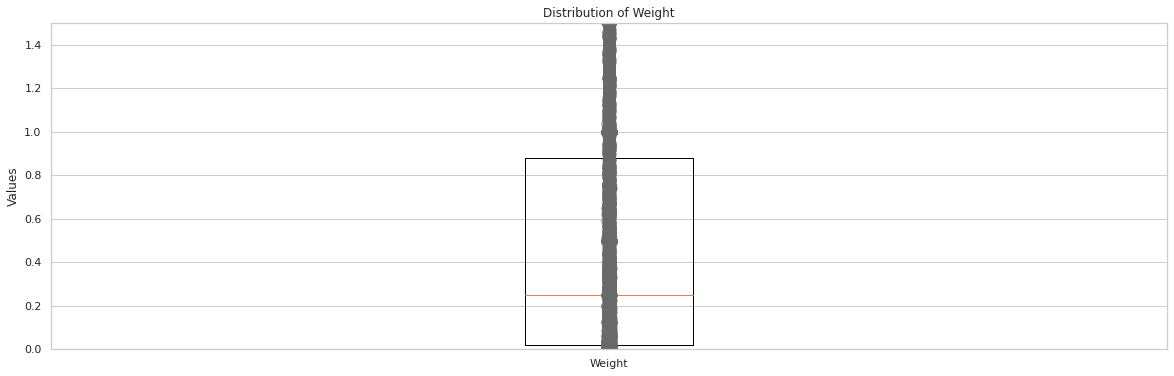

In [ ]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(bitcoin_data.weight, labels=["Weight"], showfliers=True, patch_artist=False, zorder=1)
axes.set_title("Distribution of Weight")
axes.set_ylabel("Values")
axes.set_ylim([0,1.5])
x = np.random.normal(1, 0.001, size=len(bitcoin_data["weight"]))
axes.plot(x, bitcoin_data["weight"], 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The boxplot shows skewness because the median is a lot closer to the minimum than the large side of IQR. Let's look at the histogram to see the distribution. 

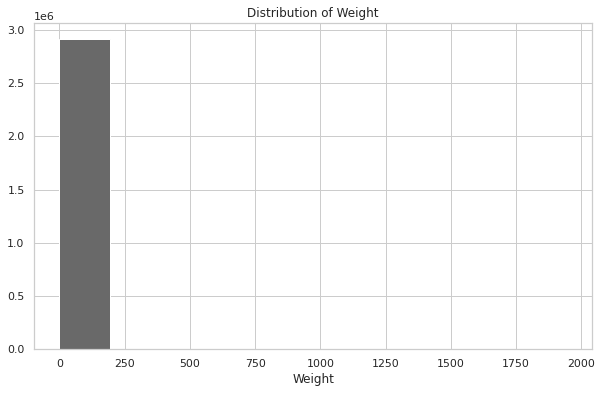

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(bitcoin_data.weight, color="DimGray")
axes.set_title("Distribution of Weight")
axes.set_xlabel("Weight")

plt.show()
plt.close()

Most of the observation is very small comparing with outliers. We can set the limit of the axis range to check the detail of the distribution in the histogram.

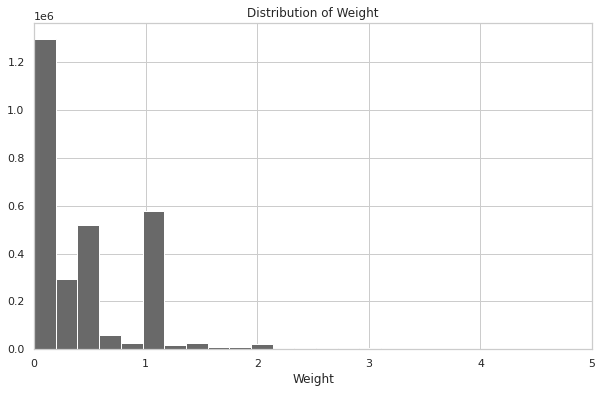

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(bitcoin_data.weight, bins = 10000, color="DimGray")
axes.set_title("Distribution of Weight")
axes.set_xlabel("Weight")
plt.xlim([0,5])

plt.show()
plt.close()

There are 3 weight numbers having high freqency, 0, 0.5 and 1. The distribution is not similar with any normal distribution nor skewness distributions.

We can apply log transformation to transform the skewed data to approximately normality, if the original data follows a log-normal distribution. Log transformation method replaces each variable x with a log(x). It may improve linearity between our dependent and independent variables 

Reference: 

https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9#:~:text=Log%20transformation%20is%20a%20data,the%20purposes%20of%20statistical%20modeling.

#### Label

Label is the name of the ransomware family. Ransomware addresses are taken from three widely adopted studies: Montreal, Princeton and Padua. Here is the researches:

* Montreal

M. Paquet-Clouston, B. Haslhofer, and B. Dupont, “Ransomware payments in the bitcoin ecosystem,” arXiv preprint arXiv:1804.04080,
2018

* Princeton

D. Y. Huang, D. McCoy, M. M. Aliapoulios, V. G. Li, L. Invernizzi,
E. Bursztein, K. McRoberts, J. Levin, K. Levchenko, and A. C. Snoeren,
“Tracking ransomware end-to-end,” in Tracking Ransomware End-toend. IEEE, 2018, pp. 1–12.


* Padua

M. Conti, A. Gangwal, and S. Ruj, “On the economic significance of
ransomware campaigns: A bitcoin transactions perspective,” Computers
& Security, 2018.


* White

non-ransomware or not known to belong to any ransomware family.


In [ ]:
label = bitcoin_data["label"].describe()
print(label)

count     2916697
unique         29
top         white
freq      2875284
Name: label, dtype: object


In [ ]:
label_sum = bitcoin_data["label"].value_counts(normalize=True)
label_sum

white                         0.98580
paduaCryptoWall               0.00425
montrealCryptoLocker          0.00319
princetonCerber               0.00316
princetonLocky                0.00227
montrealCryptXXX              0.00083
montrealNoobCrypt             0.00017
montrealDMALockerv3           0.00012
montrealDMALocker             0.00009
montrealSamSam                0.00002
montrealGlobeImposter         0.00002
montrealCryptoTorLocker2015   0.00002
montrealGlobev3               0.00001
montrealGlobe                 0.00001
montrealWannaCry              0.00001
montrealRazy                  0.00000
montrealAPT                   0.00000
paduaKeRanger                 0.00000
montrealFlyper                0.00000
montrealXTPLocker             0.00000
montrealCryptConsole          0.00000
montrealXLockerv5.0           0.00000
montrealVenusLocker           0.00000
montrealEDA2                  0.00000
montrealJigSaw                0.00000
paduaJigsaw                   0.00000
montrealXLoc

This is a categorical variable with total 29 categories. The largest portion of the categories is non-ransomware. The least shown category is montrealSam. We can take a look at the graph to visual the frequency of each category.

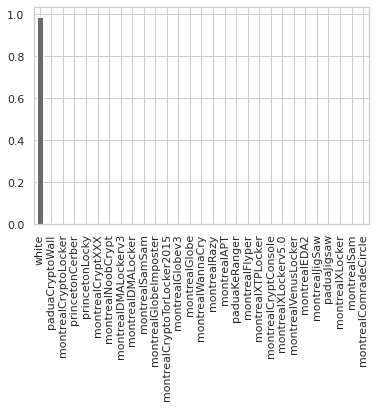

In [ ]:
label_sum.plot(kind="bar", color="DimGray")

The observations in white categories is a lot more than any other observations in categories.

If we only look at the randsomeware categories, we can tell that the top 5 categories contain the majority of the randsomeware cases.

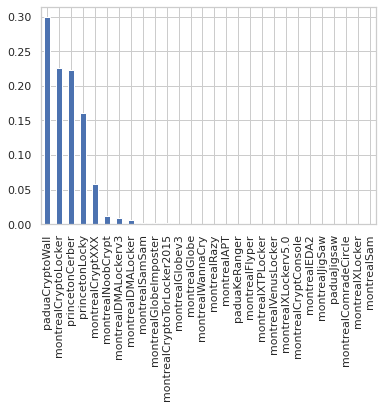

In [ ]:
nowhite = bitcoin_data[bitcoin_data.label != 'white']
label_sum_nowhite = nowhite["label"].value_counts(normalize=True)
label_sum_nowhite.plot(kind="bar")

We can separate the label in 2 groups, white and ransomware. The categories help to compare the difference between ransomware and non-ransomware.

In [ ]:
bitcoin_data['white_or_rware'] = bitcoin_data.label.apply(lambda x: 'white' if x == "white" else 'ransomware')
bitcoin_data.white_or_rware.value_counts()

white         2875284
ransomware      41413
Name: white_or_rware, dtype: int64

As we can see there are far more `white` addresses than `ransomware` address - 1,007,162 vs 41,413

### Weight vs Label
We seperate the label in 2 groups, white and ransomware. The categories help to compare the difference between ransomware and non-ransomware.

In [ ]:
grouped = bitcoin_data.groupby("white_or_rware")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["weight"].get_group("ransomware"),bins=8000,color="DimGray",density=True)
axes.set_title("Ransomware")
axes.set_xlabel("weight")
axes.set_xlim((0,5))
axes.set_ylim((0,10))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["weight"].get_group("white"),bins=8000,color="DimGray",density=True)
axes.set_title("White")
axes.set_xlabel("weight")
axes.set_xlim((0,5))
axes.set_ylim((0,10))

plt.show()
plt.close()

In [ ]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)
describe_by_category(bitcoin_data, "weight", "white_or_rware", transpose=True)

In [ ]:
nowhite_weight = nowhite[['weight','label']]
grouped = nowhite_weight.groupby(['label']).mean()
grouped["rank"] = grouped.weight.rank(ascending=False)
grouped

montrealRazy has the most weight 43.218248 and montrealComradeCircle has the less weight 0.051214. Most of the randsomware has less than 1 weight, besides montrealRazy and montrealCryptoTorLocker2015.

## Modeling

We already know from EDA that our baseline mean as a model will predict `white` with high probability -- and it'll be right the overwhelming majority of the time. 



In [ ]:
bitcoin_data.white_or_rware.value_counts(normalize=True)

white        0.95893
ransomware   0.04107
Name: white_or_rware, dtype: float64

As you can see, the overall 2016 percentage of not white (or error) is only 4.11%. Not a bad error rate for a model...but it doesn't exactly help us with the analytic issue in question.We want to see if we can beat this result. 

Establishing a general framework for our modeling approach from here, we'll:

1. Begin with all features as suggested by domain knowledge,
2. Analyze features for correlations and, of those groups, consider picking the best variable, an average of the variables, or some other transformation (sum, min, max, etc).
3. Transform all categorical variables into one hot encodings but leave one encoding out of the model for each variable. 

We also want to ensure we re-evaluate our model results in terms of expected signs and observed signs.

We'll further evaluate our models using 10 fold cross validation and learning curves.

Based on domain knowledge, we'll start with: 
`address`,
`weight`,
`income`,
`neighbors`, and
`looped`

### is_white ~ address_count + log_income + is_unique_address + log_looped

Logistic Regression for reference

In [ ]:
model = "is_white ~ address_count + log_income + is_unique_address + log_looped"
result = models.bootstrap_logistic_regression(model, bitcoin_data)
models.describe_bootstrap_lgr(result)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,-0.39,-0.53,-0.24,0.40
address_count,$\beta_{1}$,-0.11,-0.12,-0.11,-0.03
log_income,$\beta_{2}$,0.20,0.19,0.20,0.05
is_unique_address,$\beta_{3}$,0.54,0.49,0.59,0.13
log_looped,$\beta_{4}$,0.20,0.18,0.21,0.05
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),4.06,4.01,4.11,,
Efron's $R^2$,0.02,0.02,0.02,,


As you can see above our linear regression model wasn't very successful so we will attempt to use KNN. For now let's determine what the best value for K is and we'll use the same model of `is_white ~ address_count + log_income + is_unique_address + log_looped`. This can be done using validation curves

Now let's do a comparison of Linear Regression and KNN on this model

In [ ]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

Linear Regression performance

In [ ]:
scores_lr = cross_validation(model, bitcoin_data, x_cols, y_col)

In [ ]:
scores_lr = [0.9580706179066835,
 0.9585949609857342,
 0.9585424165199801,
 0.9589627722460132,
 0.9580169718624386,
 0.9588839555473819,
 0.958910227780259,
 0.9589890444788902,
 0.9586737776843653,
 0.9586475054514884,
 0.9580706179066835,
 0.9585949609857342,
 0.9585424165199801,
 0.9589627722460132,
 0.9580169718624386,
 0.9588839555473819,
 0.958910227780259,
 0.9589890444788902,
 0.9586737776843653,
 0.9586475054514884,
 0.9580706179066835,
 0.9585949609857342,
 0.9585424165199801,
 0.9589627722460132,
 0.9580169718624386,
 0.9588839555473819,
 0.958910227780259,
 0.9589890444788902,
 0.9586737776843653,
 0.9586475054514884]

KNN performance

In [ ]:
# Takes 40mins
model = KNeighborsClassifier(n_neighbors=9)
scores = cross_validation(model, bitcoin_data, x_cols, y_col)

In [ ]:
knn_bootstrap = bootstrap_sample(scores, np.mean)
lr_bootstrap = bootstrap_sample(scores_lr, np.mean)
difference = knn_bootstrap - lr_bootstrap

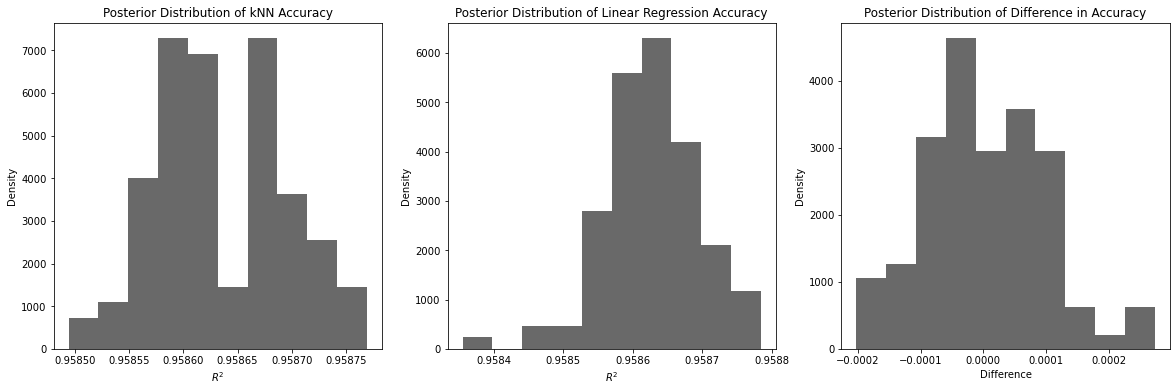

In [ ]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(knn_bootstrap, density=True, color="DimGray")
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of kNN Accuracy")

axes = figure.add_subplot(1, 3, 2)

axes.hist(lr_bootstrap, density=True,color="DimGray")
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Linear Regression Accuracy")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True,color="DimGray")
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in Accuracy")

plt.show()
plt.close()

In [ ]:
print("P(kNN > LR)", np.mean(difference > 0))
print("P(kNN < LR)", np.mean(difference < 0))

P(kNN > LR) 0.51
P(kNN < LR) 0.49


This is basically a difference of means test. Here we can see some slight evidence that that kNN is better than LR. Of course, we cannot really rule out that either approach is better, but the evidence suggests a nearly 50/50 split.

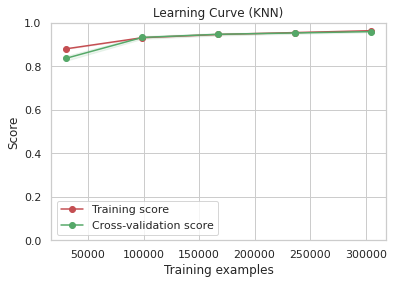

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(), X_scaled, Y)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Learning Curve (KNN)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")

plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")

plt.legend(loc="best")
plt.show()

Since our learning curves converge, our model will not benefit from more training examples.

# Conclusion
According to the analysis of the 5 linear models and 5 k nearest neighbors models, we found that k nearest neighbors perform better than linear regression in general. The best model is is_white~log_income + log_neighbors + log_address_count. When the optimal value k = 9, the model can describe 96.72% of the data. The learning curve shows that the testing and training both have excellent performance (accuracy over 90%) as the training dataset has more than 20% of the dataset. 
